<a href="https://colab.research.google.com/github/ayyucedemirbas/molecular_solubility/blob/main/solubility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 28.7 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, MolSurf, GraphDescriptors
from tensorflow.keras import layers, models, optimizers

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
def download_delaney_dataset():
    url = 'https://raw.githubusercontent.com/ayyucedemirbas/molecular_solubility/refs/heads/main/delaney-processed.csv'
    df = pd.read_csv(url)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    expected_columns = [
        "Compound ID",
        "ESOL predicted log solubility in mols per litre",
        "Minimum Degree",
        "Molecular Weight",
        "Number of H-Bond Donors",
        "Number of Rings",
        "Number of Rotatable Bonds",
        "Polar Surface Area",
        "measured log solubility in mols per litre",
        "smiles"
    ]

    for col in expected_columns:
        if col not in df.columns:
            print(f"Warning: Expected column '{col}' not found in dataset")

    return df


In [5]:
def process_smiles_data(df):
    valid_indices = []

    for i, smiles in enumerate(df['smiles']):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_indices.append(i)

    print(f"Valid molecules: {len(valid_indices)} out of {len(df)}")

    df_valid = df.iloc[valid_indices].reset_index(drop=True)

    feature_columns = [
        'Minimum Degree',
        'Molecular Weight',
        'Number of H-Bond Donors',
        'Number of Rings',
        'Number of Rotatable Bonds',
        'Polar Surface Area',
        'ESOL predicted log solubility in mols per litre'
    ]

    # Target values
    y = df_valid['measured log solubility in mols per litre'].values

    # Features
    X = df_valid[feature_columns].values

    return X, y, df_valid

In [6]:
def split_data(X, y, test_size=0.2, val_size=0.1):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_ratio, random_state=42
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def normalize_features(X_train, X_val, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # Replace zeros in std to avoid division by zero
    std = np.where(std == 0, 1, std)

    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std

    return X_train_norm, X_val_norm, X_test_norm, mean, std

In [8]:
def build_model(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)  #regression
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

In [9]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history

In [10]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R²: {r2:.4f}")

    return y_pred, mse, rmse, r2


In [11]:
def plot_results(y_test, y_pred, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    ax1.set_xlabel('Actual log(Solubility)')
    ax1.set_ylabel('Predicted log(Solubility)')
    ax1.set_title('Predicted vs Actual Solubility')

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss (MSE)')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('solubility_prediction_results.png')
    plt.show()

In [12]:
df = download_delaney_dataset()

Dataset shape: (1128, 10)
Columns: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


In [13]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [14]:
X, y, processed_df = process_smiles_data(df)

Valid molecules: 1128 out of 1128


In [15]:
 X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

Training set: 789 samples
Validation set: 113 samples
Test set: 226 samples


In [16]:
X_train_norm, X_val_norm, X_test_norm, mean, std = normalize_features(X_train, X_val, X_test)

In [17]:
model = build_model(X_train_norm.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 192 (768.00 B)

In [19]:
trained_model, history = train_model(model, X_train_norm, y_train, X_val_norm, y_val)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - loss: 9.9494 - mae: 2.5984 - val_loss: 9.6136 - val_mae: 2.6780
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7099 - mae: 1.9374 - val_loss: 8.0264 - val_mae: 2.4419
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4487 - mae: 1.4734 - val_loss: 6.3924 - val_mae: 2.1701
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5967 - mae: 1.2329 - val_loss: 5.1544 - val_mae: 1.9303
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1163 - mae: 1.1491 - val_loss: 4.0436 - val_mae: 1.7119
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1581 - mae: 1.1124 - val_loss: 3.1752 - val_mae: 1.5208
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6314 - mae: 0.9884 - val_loss: 2.6552 - val_mae: 1.3773
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5817 - mae: 0.9771 - val_loss: 2.1659 - val_mae: 1.2345
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

In [20]:
y_pred, mse, rmse, r2 = evaluate_model(trained_model, X_test_norm, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Test MSE: 0.5974
Test RMSE: 0.7729
Test R²: 0.8736


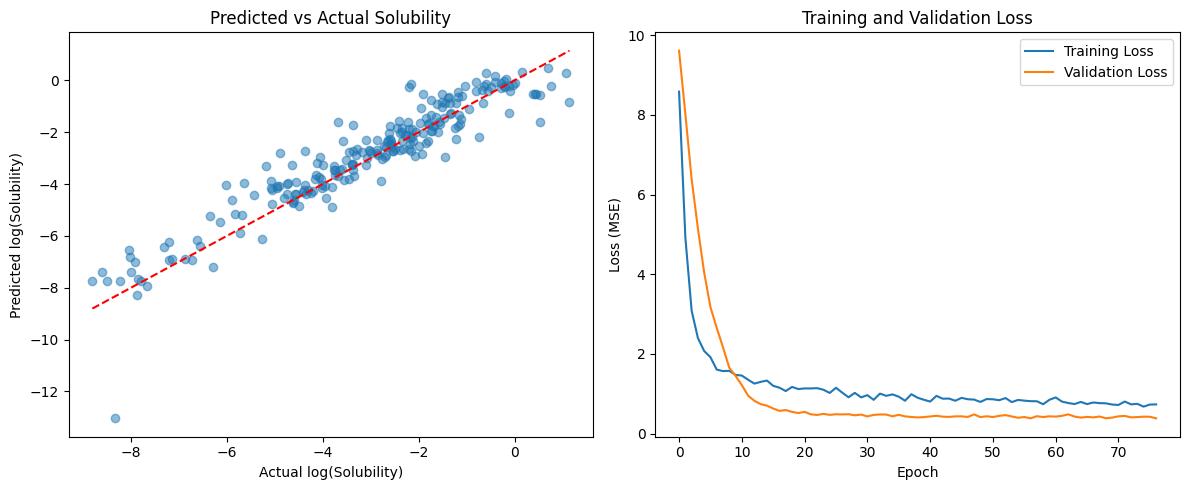

In [21]:
plot_results(y_test, y_pred, history)

In [22]:
 trained_model.save('solubility_model.h5')